### Importing Libraries


In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils import resample
import os
import glob
from datetime import datetime

In [2]:
train = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_ids.csv")
train_dir = "train"
test_dir = "test"
print(train.head())
print(test.head())

           image_id      soil_type
0  img_ed005410.jpg  Alluvial soil
1  img_0c5ecd2a.jpg  Alluvial soil
2  img_ed713bb5.jpg  Alluvial soil
3  img_12c58874.jpg  Alluvial soil
4  img_eff357af.jpg  Alluvial soil
            image_id
0  img_cdf80d6f.jpeg
1   img_c0142a80.jpg
2   img_91168fb0.jpg
3   img_9822190f.jpg
4  img_e5fc436c.jpeg


### Preprocessing the Image Data and Loading Train/Test Data


In [3]:
train_data = pd.DataFrame()

# Loop through all files in the training directory
train_data_list = []
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        # There are RGBA or P images as well. Hence convert to RGB
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        # Match filename with train[image_id]
        match = train[train['image_id'] == filename]
        if not match.empty:
            soil_type = match.iloc[0]['soil_type']
            train_data_list.append(
                {'image_id': filename, 'image_data': image, 'soil_type': soil_type})

train_data = pd.DataFrame(train_data_list)

print(train_data.head())

           image_id                                         image_data  \
0  img_000b2d34.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
1  img_002544b5.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
2  img_00317510.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
3  img_005e8551.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   
4  img_009a3c89.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...   

       soil_type  
0      Clay soil  
1  Alluvial soil  
2       Red soil  
3      Clay soil  
4     Black Soil  


In [4]:
test_data = pd.DataFrame()

# Loop through all files in the testing directory
test_data_list = []
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        test_data_list.append({'image_id': filename, 'image_data': image})

test_data = pd.DataFrame(test_data_list)

print(test_data.head())

           image_id                                         image_data
0  img_000f12db.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
1  img_00a44450.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
2  img_00af6b3b.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
3  img_01a3f913.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...
4  img_01e540fc.jpg  <PIL.Image.Image image mode=RGB size=224x224 a...


### Converting Soil Types into Integers


In [5]:
unique_soil_types = train_data['soil_type'].unique()

In [6]:
soil_type_mapping = {soil: idx for idx, soil in enumerate(unique_soil_types)}
print(soil_type_mapping)

train_data['soil_type'] = train_data['soil_type'].map(soil_type_mapping)

{'Clay soil': 0, 'Alluvial soil': 1, 'Red soil': 2, 'Black Soil': 3}


### Visualizing the train data


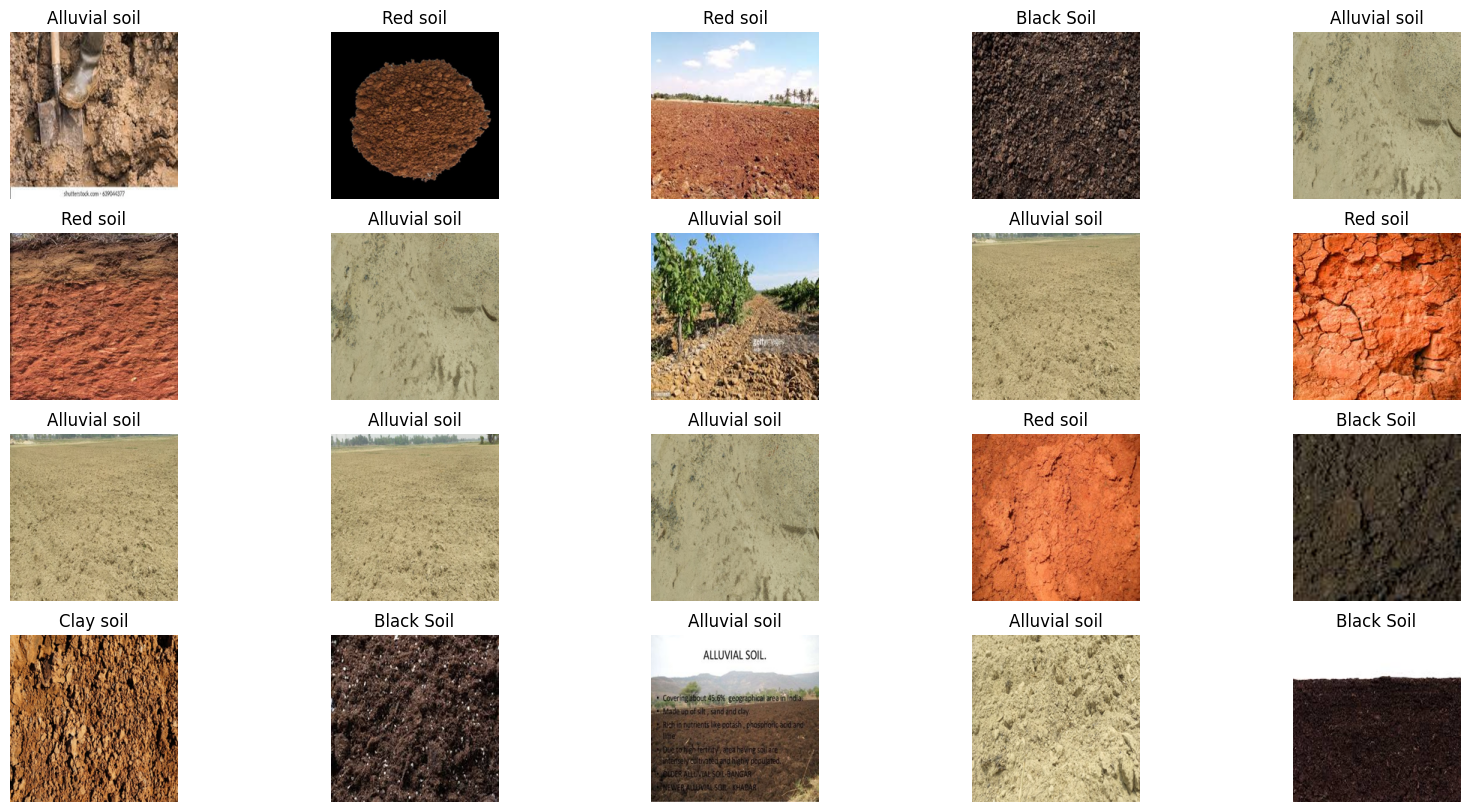

In [7]:
# Visualizing 20 random images from the training dataset
def visualize_data(data, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(data), size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(4, 5, i + 1)
        plt.imshow(data['image_data'].iloc[idx])
        label_idx = data['soil_type'].iloc[idx]
        label_name = [k for k, v in soil_type_mapping.items()
                      if v == label_idx][0]
        plt.title(label_name)
        plt.axis('off')
    plt.show()


visualize_data(train_data, num_images=20)

In [8]:
# print train and test data shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1222, 3)
Test data shape: (341, 2)


### SOIL DataSet Class


In [9]:
class SoilDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data['image_data'].iloc[idx]
        if 'soil_type' in self.data.columns:
            label = self.data['soil_type'].iloc[idx]
        else:
            label = -1

        if self.transform:
            image = self.transform(image)

        return image, label

### Checking for Class Imbalance


Clay soil: 199
Alluvial soil: 528
Red soil: 264
Black Soil: 231


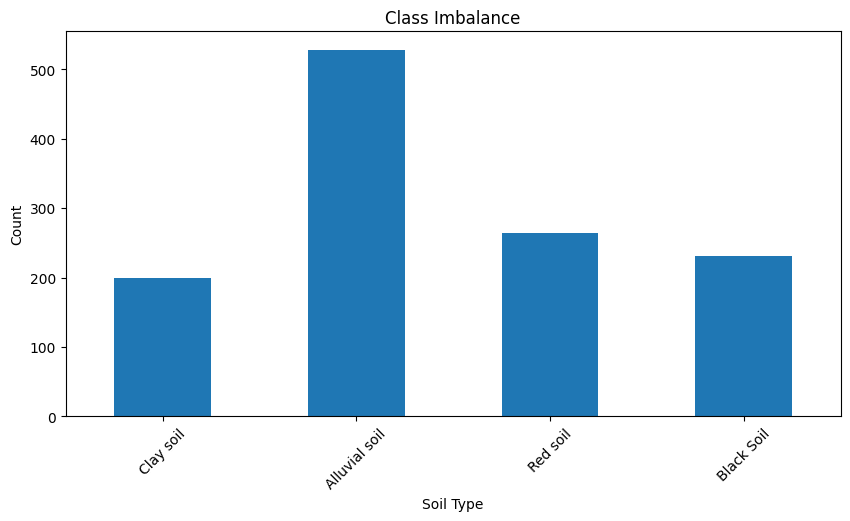

In [10]:
# check for class imbalance
def check_class_imbalance(data):
    class_counts = data['soil_type'].value_counts().sort_index()
    for idx, count in class_counts.items():
        soil_name = [k for k, v in soil_type_mapping.items() if v == idx][0]
        print(f"{soil_name}: {count}")
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Imbalance')
    plt.xlabel('Soil Type')
    plt.ylabel('Count')
    labels = [k for k, v in sorted(
        soil_type_mapping.items(), key=lambda item: item[1])]
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.show()


check_class_imbalance(train_data)

### Oversample minority classes to fix class imbalance


In [11]:
# # Seperate by class
# dfs = []
# for class_idx in range(len(soil_type_mapping)):
#     class_df = train_data[train_data['soil_type'] == class_idx]
#     dfs.append(class_df)

# # Find the maximum class size
# max_size = max([len(df) for df in dfs])

# # Resample each class to the max size
# dfs_balanced = [
#     resample(df, replace=True, n_samples=max_size, random_state=42)
#     for df in dfs
# ]

# # Concatenate back into a single DataFrame
# train_data_balanced = pd.concat(dfs_balanced).reset_index(drop=True)

# # Shuffle the balanced dataset
# train_data = train_data_balanced.sample(
#     frac=1, random_state=42).reset_index(drop=True)

# # Check new class distribution
# check_class_imbalance(train_data)

### Data Augmentation Pipeline and Dataloaders


In [12]:
# create transforms to normalize and augment the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_split, val_split = train_test_split(
    train_data, test_size=0.2, stratify=train_data['soil_type'], random_state=42)

# Create datasets and dataloaders
train_dataset = SoilDataset(train_split, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SoilDataset(val_split, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = SoilDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### CNN Model


In [13]:
class SOILNet(nn.Module):
    def __init__(self, num_classes=len(soil_type_mapping)):
        super(SOILNet, self).__init__()
        self.features = nn.Sequential(
            # 224x224x3 -> 224x224x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 224x224x32 -> 112x112x32

            # 112x112x32 -> 112x112x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112x64 -> 56x56x64

            # 56x56x64 -> 56x56x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56x128 -> 28x28x128

            # 28x28x128 -> 28x28x256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28x256 -> 14x14x256
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = SOILNet().to(device)

In [14]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(soil_type_mapping))
model = model.to(device)

/home/godwildbeast/virtenvs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/godwildbeast/virtenvs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/godwildbeast/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:11<00:00, 7.55MB/s]


In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Training Loop


In [16]:
def calculate_metrics(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='macro')
    acc = accuracy_score(targets, preds)
    return acc, precision, recall, f1


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    # Create timestamped output directory
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = os.path.join("checkpoints", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    best_val_loss = float('inf')
    all_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_targets = [], []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        if scheduler:
            scheduler.step()

        # Compute training metrics
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='macro')
        train_acc = accuracy_score(train_targets, train_preds)
        train_loss = running_loss / len(train_loader)

        # Compute validation metrics
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_acc, val_precision, val_recall, val_f1 = calculate_metrics(
            model, val_loader)

        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        print(
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best model by validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(output_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(
                f"✅ Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Store metrics
        all_metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
        })

    # Save all metrics to a CSV
    df_metrics = pd.DataFrame(all_metrics)
    metrics_path = os.path.join(output_dir, "training_metrics.csv")
    df_metrics.to_csv(metrics_path, index=False)
    print(f"📊 Metrics saved to {metrics_path}")

In [17]:
train_model(model, train_loader, val_loader, criterion,
            optimizer, scheduler, num_epochs=30)


Epoch [1/30]
Train Loss: 0.6984 | Train Acc: 0.7646 | Train F1: 0.7370
Val Loss: 0.8696 | Val Acc: 0.7102 | Val F1: 0.7439
✅ Best model saved at epoch 1 with val loss 0.8696

Epoch [2/30]
Train Loss: 0.4652 | Train Acc: 0.8229 | Train F1: 0.8138
Val Loss: 0.4366 | Val Acc: 0.8980 | Val F1: 0.8922
✅ Best model saved at epoch 2 with val loss 0.4366

Epoch [3/30]
Train Loss: 0.4068 | Train Acc: 0.8710 | Train F1: 0.8657
Val Loss: 0.3265 | Val Acc: 0.8857 | Val F1: 0.8799
✅ Best model saved at epoch 3 with val loss 0.3265

Epoch [4/30]
Train Loss: 0.3565 | Train Acc: 0.8782 | Train F1: 0.8683
Val Loss: 0.4990 | Val Acc: 0.8735 | Val F1: 0.8746

Epoch [5/30]
Train Loss: 0.3198 | Train Acc: 0.8854 | Train F1: 0.8768
Val Loss: 0.2659 | Val Acc: 0.9306 | Val F1: 0.9285
✅ Best model saved at epoch 5 with val loss 0.2659

Epoch [6/30]
Train Loss: 0.2358 | Train Acc: 0.9222 | Train F1: 0.9188
Val Loss: 0.2154 | Val Acc: 0.9551 | Val F1: 0.9519
✅ Best model saved at epoch 6 with val loss 0.2154



### Visualizing Predictions on Validation Set


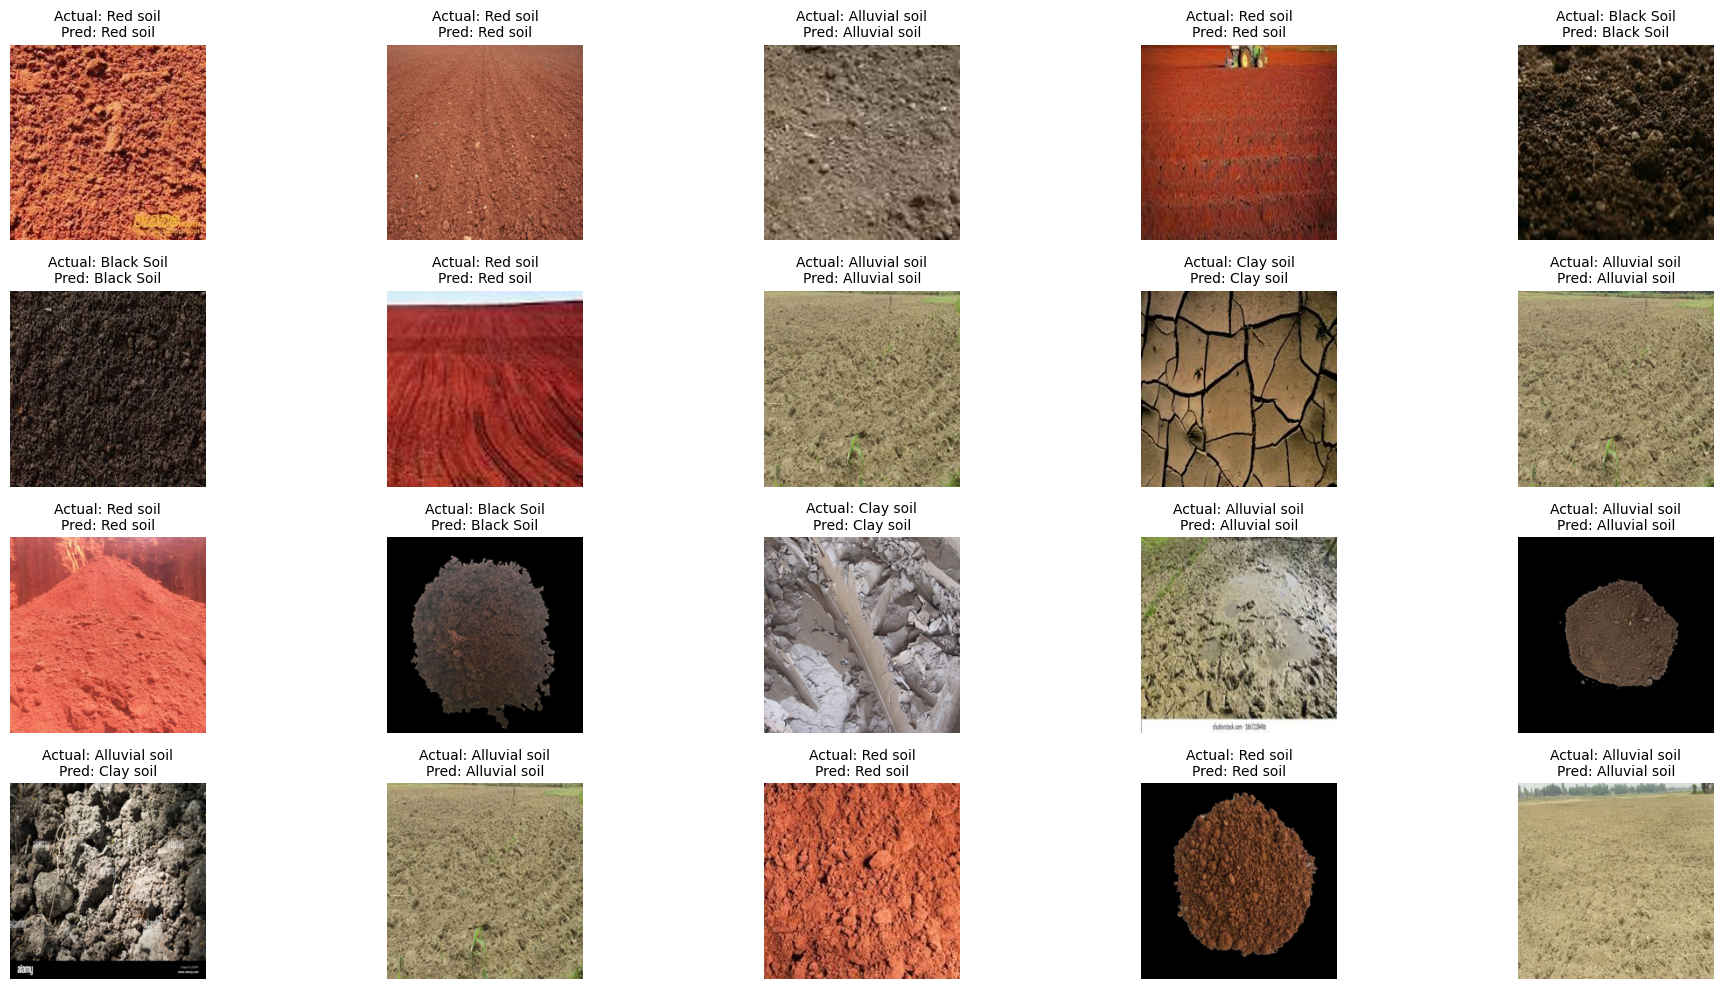

In [18]:
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_val_predictions(model, val_loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(val_loader.dataset),
                            size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            image, actual_label = val_loader.dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            outputs = model(image_input)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            plt.subplot(4, 5, i + 1)
            pil_img = val_loader.dataset.data['image_data'].iloc[idx]
            plt.imshow(pil_img)
            actual_name = [k for k, v in soil_type_mapping.items()
                           if v == actual_label][0]
            predicted_name = [
                k for k, v in soil_type_mapping.items() if v == predicted_label][0]
            plt.title(
                f"Actual: {actual_name}\nPred: {predicted_name}", fontsize=10)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_val_predictions(model, val_loader, num_images=20)

### VIsualizing Predictions on Test Set


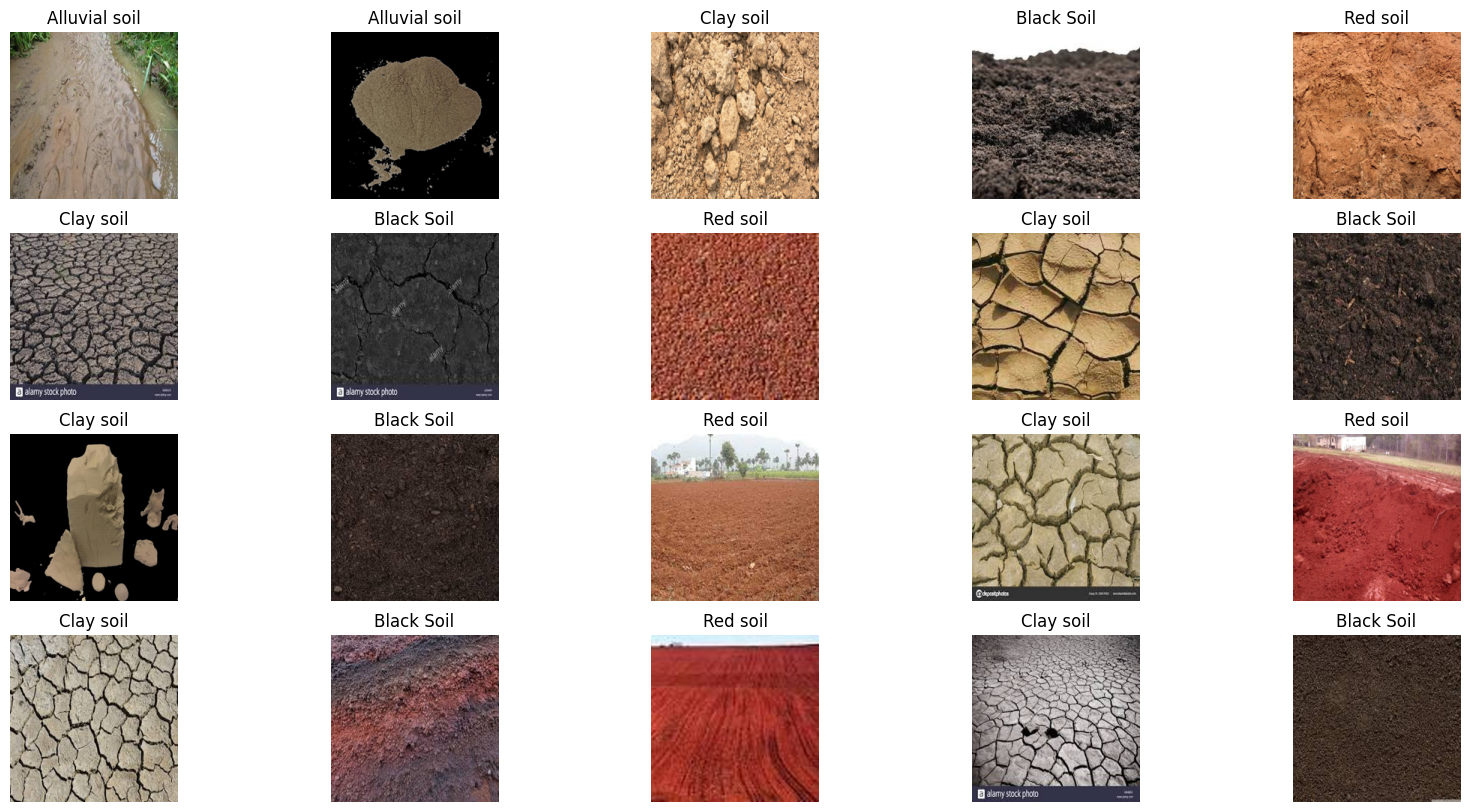

In [19]:
checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")


def visualize_predictions(model, test_loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(test_loader.dataset),
                            size=num_images, replace=False)
    plt.figure(figsize=(20, 10))
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            images, _ = test_loader.dataset[idx]
            images = images.unsqueeze(0).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

            plt.subplot(4, 5, i + 1)
            plt.imshow(test_loader.dataset.data['image_data'].iloc[idx])
            label_name = [k for k, v in soil_type_mapping.items()
                          if v == predicted_label][0]
            plt.title(label_name)
            plt.axis('off')
    plt.show()


visualize_predictions(model, test_loader, num_images=20)

### Confusion Matrix


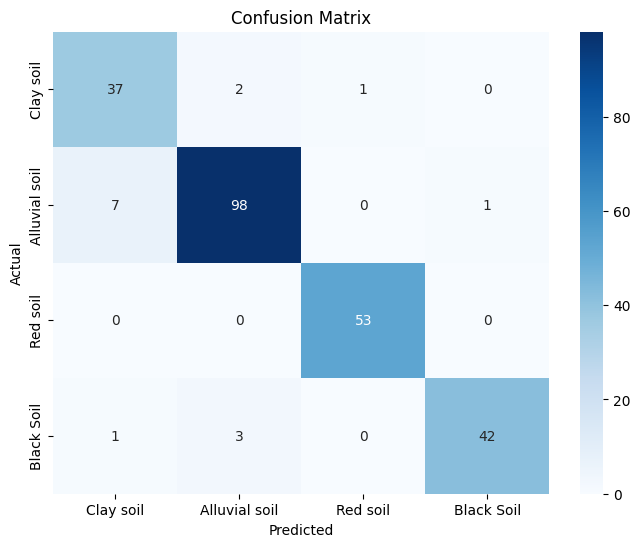

Classification Report:

               precision    recall  f1-score   support

    Clay soil      0.822     0.925     0.871        40
Alluvial soil      0.951     0.925     0.938       106
     Red soil      0.981     1.000     0.991        53
   Black Soil      0.977     0.913     0.944        46

     accuracy                          0.939       245
    macro avg      0.933     0.941     0.936       245
 weighted avg      0.942     0.939     0.939       245



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions and true labels for the validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [k for k, v in sorted(
    soil_type_mapping.items(), key=lambda item: item[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(
    all_labels, all_preds, target_names=class_names, digits=3)
print("Classification Report:\n")
print(report)

In [21]:
def generate_submission(model, test_loader, output_path='submission.csv'):
    model.eval()
    preds = []
    image_ids = test_data['image_id'].tolist()

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())

    inv_mapping = {v: k for k, v in soil_type_mapping.items()}
    labels = [inv_mapping[p] for p in preds]

    submission = pd.DataFrame({'image_id': image_ids, 'soil_type': labels})
    submission.to_csv(output_path, index=False)


checkpoint_dirs = glob.glob(os.path.join("checkpoints", "*"))
if checkpoint_dirs:
    latest_dir = max(checkpoint_dirs, key=os.path.getmtime)
    best_model_path = os.path.join(latest_dir, "best_model.pth")
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
    else:
        print("No best_model.pth found in the latest checkpoint directory.")
else:
    print("No checkpoint directories found.")

generate_submission(model, test_loader, output_path='submission.csv')